In [90]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import requests
from bs4 import BeautifulSoup, Comment
from tqdm import tqdm
import pandas as pd
from sports_ref_scraper.parsing import extract_table, find_table, list_tables
from sports_ref_scraper.scraping import get_year_stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
url_formatter = 'https://www.basketball-reference.com/leagues/NBA_{year}_advanced.html'

In [14]:
data = get_year_stats(url_formatter, 2019, 'advanced_stats')

In [47]:
all_dfs = []
for year in tqdm(range(2000, 2020)):
    all_dfs.append(get_year_stats(url_formatter, year, 'advanced_stats'))

100%|██████████| 20/20 [00:36<00:00,  1.81s/it]


In [51]:
all_df = pd.concat(all_dfs)

In [66]:
def filter_df(df):
    def _get_id(df):
        return df['player_url'] + '___' + df['year'].astype(str)
    vals = set(_get_id(df[df['team_id'] == 'TOT']))
    return df[~(_get_id(df).isin(vals) & (df['team_id'] != 'TOT'))]

In [67]:
all_df = filter_df(all_df)

In [70]:
prev_year_df = all_df.copy()
prev_year_df['year'] += 1


In [72]:
merged_df = all_df.merge(prev_year_df, how='left', on=['player_url', 'year'], suffixes=('', '___1'))

In [79]:
merged_df['bpm'] = merged_df['bpm'].astype(float)
merged_df['bpm___1'] = merged_df['bpm___1'].astype(float)
merged_df['mp'] = merged_df['mp'].astype(float)
merged_df['mp___1'] = merged_df['mp___1'].astype(float)

In [80]:
merged_df['diff'] = merged_df['bpm'] - merged_df['bpm___1']

In [82]:
merged_df['mp_avg'] = 2 / (1/ merged_df['mp'] + 1/merged_df['mp___1'])

In [84]:
def _calc_delta(df):
    df = df.dropna(subset=['mp_avg', 'diff'])
    return (df['diff'] * df['mp_avg']).sum() / df['mp_avg'].sum()

In [85]:
age = merged_df.groupby('age').apply(_calc_delta)

/Users/harrisonchase/workplace/sports_ref_scraper/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


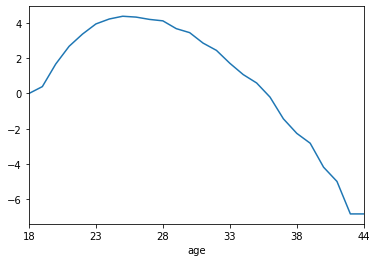

In [91]:
age.fillna(0).cumsum().plot()